In [2]:
import os
import sys
import warnings
import itertools
import math
import logging
import json
import re
import random
from pathlib import Path
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Import Mask RCNN
from mrcnn import utils
from mrcnn.visualize import display_images, display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

from corebreakout import defaults
from corebreakout.datasets import PolygonDataset

%matplotlib inline

Using TensorFlow backend.


## Model Config

In [3]:
class PolygonConfig(Config):
    '''Override some base config values.'''
    NAME = 'labelme'

    # TODO: STD_DEVs?

    # Model Config
    NUM_CLASSES = 1 + 2                     # (background, col, tray)
    BACKBONE = 'resnet101'
    RPN_ANCHOR_SCALES = (64, 128, 192, 320, 352)
    RPN_ANCHOR_RATIOS = [1/7, 1/4, 1, 4, 7] # [0.5, 1, 2]
    RPN_NMS_THRESHOLD = 0.7 # 0.7

    DETECTION_MAX_INSTANCES = 6
    DETECTION_MIN_CONFIDENCE = 0.95

    # Training Config
    STEPS_PER_EPOCH = 17
    VALIDATION_STEPS = 3

    # ... for Ross' home
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # ... for CoRE machine
    #GPU_COUNT = 2
    #IMAGES_PER_GPU = 1 # (Maybe can get away with 2?)
    
config = PolygonConfig()

## Load Datasets

In [4]:
dataset = PolygonDataset()
dataset.collect_annotated_images(defaults.DATASET_DIR, 'train')
dataset.prepare()

print(dataset)


 PolygonDataset
Image count : 17
Class count : 3
  0. BG                                                
  1. col                                               
  2. tray                                              


In [5]:
test_dataset = PolygonDataset()
test_dataset.collect_annotated_images(defaults.DATASET_DIR, 'test')
test_dataset.prepare()

print(test_dataset)


 PolygonDataset
Image count : 3
Class count : 3
  0. BG                                                
  1. col                                               
  2. tray                                              


## Load ~~a test well~~ some random test images

In [6]:
import glob
from skimage import io

test_dir = '/home/'+os.environ['USER']+'/Dropbox/core_data/well_core_data/wos_data/schiehallion-complex/204-19-6/converted/'
test_img_files = sorted(glob.glob(test_dir+'*.jpeg'))
test_imgs = [io.imread(f) for f in test_img_files]

In [7]:
def test_model(model):
    for img in test_imgs:
        test, _, _, _, _ = utils.resize_image(img, max_dim=1024)
        results = model.detect([test], verbose=0)
        r = results[0]
        display_instances(test, r['rois'], r['masks'], r['class_ids'], 
                            ['BG','core_column'], r['scores'], figsize=(10, 10))

# Changing anchor scales and ratios to reflect prior knowlege + increasing min_confidence slightly

In [8]:
#config.RPN_ANCHOR_SCALES = (64, 128, 192, 320, 352)
config.RPN_ANCHOR_RATIOS = [1/7, 1/4, 1] #, 4, 7]
#config.RPN_NMS_THRESHOLD = 0.7

#config.DETECTION_MIN_CONFIDENCE = 0.95
#config.DETECTION_MAX_INSTANCES = 6

# turn up mask loss a bit
#config.LOSS_WEIGHTS = {
#        "rpn_class_loss": 1.,
#        "rpn_bbox_loss": 1.,
#        "mrcnn_class_loss": 1.,
#        "mrcnn_bbox_loss": 1.,
#        "mrcnn_mask_loss": 1.}

MODEL_DIR = defaults.INCLUDE_DIR / 'models'

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=str(MODEL_DIR))

model.load_weights(str(defaults.COCO_MODEL_PATH), by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

W0812 14:58:58.858926 140399562770240 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 14:58:58.868764 140399562770240 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 14:58:58.892147 140399562770240 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 14:58:58.909662 140399562770240 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is d

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    model.train(dataset, test_dataset, 
                learning_rate=config.LEARNING_RATE, 
                epochs=15, 
                layers='heads')

W0812 14:46:53.850996 140445423527744 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.




Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ross/code/python/corebreakout/include/models/labelme20190812T1446/mask_rcnn_labelme_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (T

W0812 14:46:56.861277 140445423527744 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0812 14:46:56.862087 140445423527744 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/15
 1/17 [>.............................] - ETA: 19:16 - loss: 6.3151 - rpn_class_loss: 1.5471 - rpn_bbox_loss: 3.1051 - mrcnn_class_loss: 1.6630 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

Process ForkPoolWorker-37:
Process ForkPoolWorker-32:
Process ForkPoolWorker-21:
Process ForkPoolWorker-34:
Process ForkPoolWorker-22:
Process ForkPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-16:
Process ForkPoolWorker-27:
Process ForkPoolWorker-36:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap


  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/ker

  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/io/manage_plugins.py", line 210, in call_plugin
    return func(*args, **kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 903, in resize
    anti_aliasing_sigma=anti_aliasing_sigma)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/utils.py", line 359, in load_image
    image = skimage.io.imread(self.image_info[image_id]['path'])
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/core/format.py", line 214, in __init__
    self._open(**self.re

  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/core/functions.py", line 143, in get_reader
    return format.get_reader(request)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/transform/_warps.py", line 179, in resize
    preserve_range=preserve_range)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/core/format.py", line 214, in __init__
    self._open(**self.request.kwargs.copy())
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/core/functions.py", line 221, in imread
    reader = read(uri, format, "i", **kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/core/format.py", line 164, in get_reader
    return self.Reader(self, request)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/numpy/core/_methods.py", line 28, in _amax
    return umr_maximum(a, axis, None, out, keepdims, initial)
  File "/home/ross/an

  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/plugins/pillow.py", line 137, in _open
    pil_try_read(self._im)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/plugins/pillow.py", line 137, in _open
    pil_try_read(self._im)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/plugins/pillow.py", line 518, in pil_try_read
    im.getdata()[0]
  File 

  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
Traceback (most recent call last):
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/imageio/plugins/pillow.py", line 518, in pil_try_read
    im.getdata()[0]
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/ross/anaconda3

  File "/home/ross/code/python/corebreakout/corebreakout/datasets/polygondataset.py", line 84, in ann_to_mask
    rr, cc = skimage.draw.polygon(boundary[:,1], boundary[:,0])
  File "/home/ross/code/python/corebreakout/corebreakout/datasets/polygondataset.py", line 84, in ann_to_mask
    rr, cc = skimage.draw.polygon(boundary[:,1], boundary[:,0])
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "skimage/transform/_warps_cy.pyx", line 122, in skimage.transform._warps_cy._warp_fast
  File "/home/ross/code/python/corebreakout/corebreakout/datasets/polygondataset.py", line 84, in ann_to_mask
    rr, cc = skimage.draw.polygon(boundary[:,1], boundary[:,0])
  File "/home/ross/code/python/corebreakout/corebr

KeyboardInterrupt
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-17:
  File "/home/ross/code/python/corebreakout/corebreakout/datasets/polygondataset.py", line 65, in load_mask
    return self.ann_to_mask(ann_json)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-

  File "/home/ross/code/python/corebreakout/corebreakout/datasets/polygondataset.py", line 84, in ann_to_mask
    rr, cc = skimage.draw.polygon(boundary[:,1], boundary[:,0])
  File "/home/ross/code/python/corebreakout/corebreakout/datasets/polygondataset.py", line 84, in ann_to_mask
    rr, cc = skimage.draw.polygon(boundary[:,1], boundary[:,0])
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/draw/draw.py", line 452, in polygon
    return _polygon(r, c, shape)
  File "/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/skimage/draw/draw.py", line 452, in polygon
    return _polygon(r, c, shape)
KeyboardInterrupt
KeyboardInterrupt
  Fil

KeyboardInterrupt: 

In [45]:
config.DETECTION_MIN_CONFIDENCE = 0.925

model = modellib.MaskRCNN(mode='inference', config=config, 
                          model_dir=str(defaults.INCLUDE_DIR / 'models/labelme20190424T1505'))

model.load_weights(str(defaults.INCLUDE_DIR / 'models/labelme20190424T1505/mask_rcnn_labelme_0029.h5'),
                   by_name=True)

Re-starting from epoch 29


In [46]:
training_img = dataset.load_image(0)

preds = model.detect([training_img], verbose=0)[0]

preds

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


{'rois': array([[ 527,   50, 3020, 1570],
        [ 298,  142, 3027,  479],
        [ 473, 1217, 1181, 1560],
        [ 241,  615, 2989, 1628],
        [ 400, 1705, 2908, 1759],
        [ 584,   69, 3093,  125]], dtype=int32),
 'class_ids': array([2, 1, 1, 1, 3, 3], dtype=int32),
 'scores': array([0.9991412 , 0.9986545 , 0.99486274, 0.98972756, 0.96557504,
        0.96068937], dtype=float32),
 'masks': array([[[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         ...,
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],
 
        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         ...,
         [False, False, False, False, False, False],
         [False, False, False, Fal

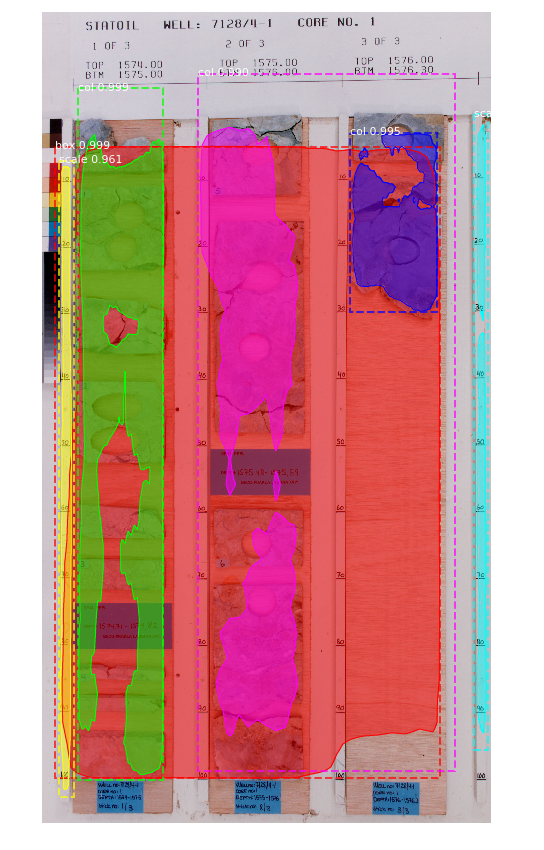

In [47]:
display_instances(training_img, preds['rois'], preds['masks'], preds['class_ids'],
                 dataset.class_names, preds['scores'], figsize=(15,15))

In [9]:
test_epochs = [24]

for e in test_epochs:
    # Create the model in inference mode
    model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

    # Path to saved weights
    model_path = os.path.join(MODEL_DIR+'/core20180920T1528/', 'mask_rcnn_core_00'+str(e)+'.h5')

    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    
    test_model(model)

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

In [ ]:
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Path to saved weights
model_path = os.path.join(MODEL_DIR+'/core20180801T1515/', 'mask_rcnn_core_0066.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
import pandas as pd
from skimage import morphology, measure

In [ ]:
col_endpts = (815, 6775)

depth_df = pd.read_csv(test_dir+'204-19-6_depths.csv')

def masks_to_labels(masks):
    labels = np.zeros((masks.shape[0], masks.shape[1]))
    for i in range(masks.shape[-1]):
        labels += (i+1)*masks[:,:,i].astype(int)
    return labels.astype(int)

def crop_to_column(img, labels, region):
    x0, y0, x1, y1 = region.bbox
    if y0 > col_endpts[0]:
        y0 = col_endpts[0]
    if y1 < col_endpts[1]:
        y1 = col_endpts[1]
    #region_mask = np.expand_dims((labels==region.label)[:,:,None]
    region_img = img * np.expand_dims(labels==region.label, -1)
    return region_img[x0:x1,y0:y1,:]
    

for i in range(len(test_imgs)-1):
    img_pred = model.detect([test_imgs[i]])[0]
    depth_range = (depth_df.top[i], depth_df.bottom[i])
    labels = masks_to_labels(img_pred['masks'])
    
    # get regions, sort top to bottom
    regions = measure.regionprops(labels)
    regions.sort(key=lambda x: x.bbox[0])
    for prop in regions:
        col = crop_to_column(test_imgs[i], labels, prop)
        plt.imshow(np.rot90(col, k=3))
        plt.show()
    
    plt.imshow(test_imgs[i])
    plt.show()
    
    
    

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=get_ax())

In [ ]:
results = model2.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Recreate the model in inference mode
model2 = modellib.MaskRCNN(mode="training", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path2 = os.path.join(MODEL_DIR+'/core20180726T0436/', 'mask_rcnn_core_0050.h5')
#model_path2 = model2.find_last()

# Load trained weights
print("Loading weights from ", model_path2)
model2.load_weights(model_path2, by_name=True)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    model2.train(dataset, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='all')

In [ ]:
image = original_image

anchors = model2.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model2.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model2.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

In [ ]:
mrcnn = model2.run_graph([original_image], [
    ("proposals", model2.keras_model.get_layer("ROI").output),
    ("probs", model2.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model2.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model2.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model2.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(original_image, boxes=proposals[ixs],
                     #visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

In [ ]:
a = (1,2,3)
a[0:-1]

In [ ]:
type(config)